#Importing necessary libraries and setting up the environment

In [ ]:
# Importing necessary libraries for data manipulation, model creation, and training
# 'files' is for uploading the 'kaggle.json' file to download the dataset
# 'ImageDataGenerator' is for data augmentation and normalization

from google.colab import files
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image


# Upload the 'kaggle.json' file for downloading the dataset
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sthomas0811","key":"bba81c95c597187442a28a901ba698b2"}'}

#Downloading and unpacking the dataset

In [ ]:
# Setting up the Kaggle directory to download the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Creating a directory for the dataset and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

# Downloading the dataset from Kaggle and returning to the previous directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

# Unzipping the downloaded file, removing unusable file, and unpacking the data
!unzip -q dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv


/content/dog_dataset
 99% 687M/691M [00:04<00:00, 222MB/s]
100% 691M/691M [00:04<00:00, 150MB/s]
/content


##Data Loading and Preprocessing

In [ ]:
labels_all = pd.read_csv("dog_dataset/labels.csv")
labels_all["id"] = labels_all["id"].apply(lambda x: x + ".jpg")

##Visualizing the Distribution of Dog Breeds

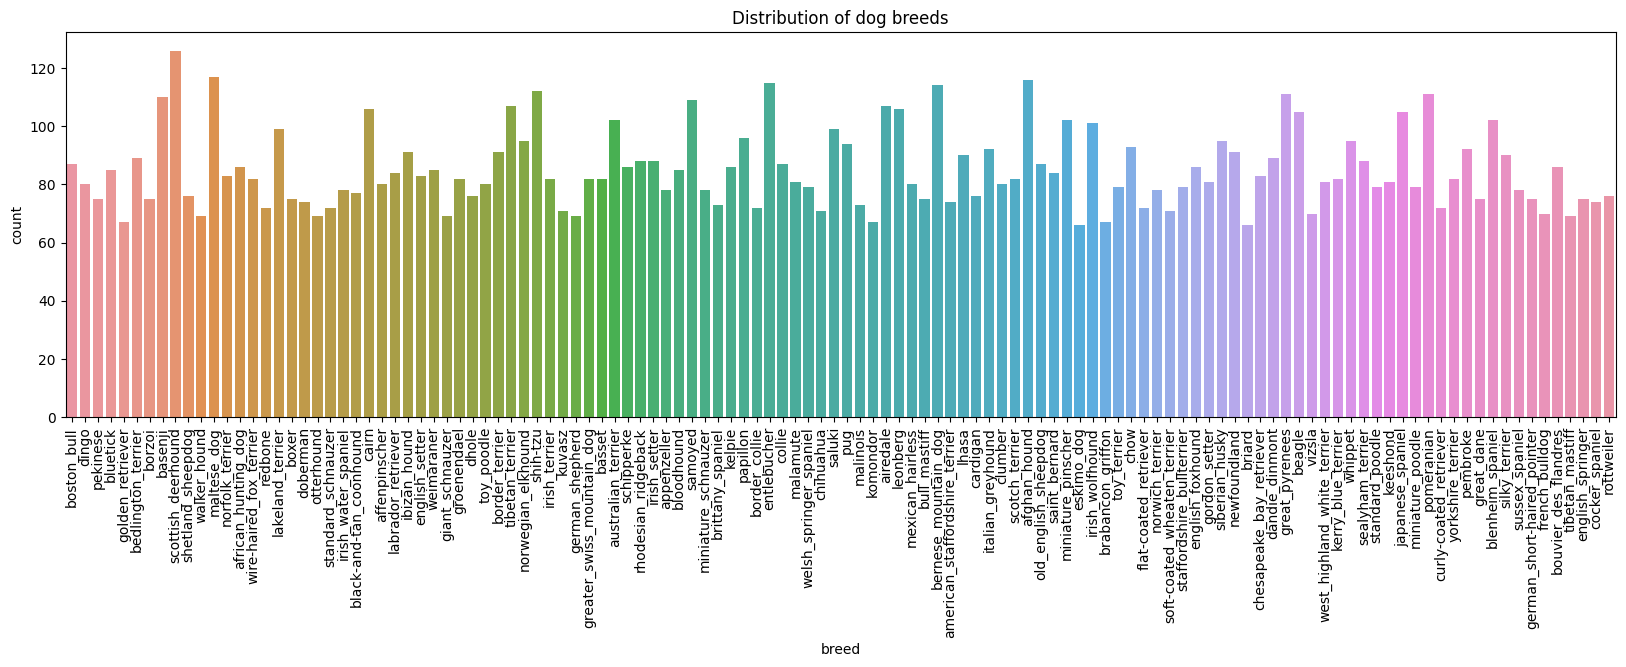

In [ ]:

plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.countplot(data=labels_all, x='breed')
plt.title('Distribution of dog breeds')
plt.show()


##Splitting the Dataset into Training, Validation, and Test Sets

In [ ]:
# Load and prepare data
RANDOM_STATE = 42
train_df, test_df = train_test_split(labels_all, test_size=0.1, random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=RANDOM_STATE)


##Previewing Dog Images from the Training Set

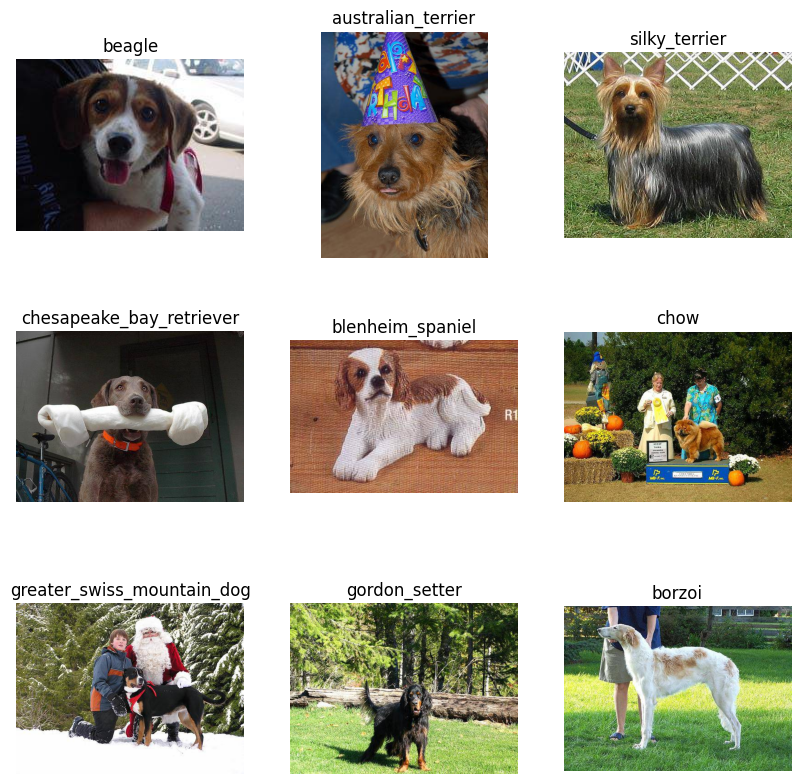

In [ ]:

# Sample some images
sample_images = train_df.sample(n=9)
plt.figure(figsize=(10,10))

for ind, image_id in enumerate(sample_images['id']):
    img = cv2.imread(f'dog_dataset/train/{image_id}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, ind+1)
    plt.imshow(img)
    plt.title(sample_images.iloc[ind]['breed'])
    plt.axis('off')

plt.show()

##Analyzing the Size of Dog Images



In [ ]:


image_sizes = [Image.open(f'dog_dataset/train/{img_id}').size for img_id in train_df['id']]

# Print some stats about image sizes
print(f'Min width: {min(sz[0] for sz in image_sizes)}')
print(f'Max width: {max(sz[0] for sz in image_sizes)}')
print(f'Min height: {min(sz[1] for sz in image_sizes)}')
print(f'Max height: {max(sz[1] for sz in image_sizes)}')


Min width: 97
Max width: 3264
Min height: 103
Max height: 2562


##Setting Up Model Constants

In [ ]:

# Constants
SIZE = (350,350)
BATCH_SIZE = 32
NUM_CLASSES = len(labels_all['breed'].unique())
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.7
EPOCHS = 5

##Setting up Image Data Generators

In [ ]:

# Image processing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_dataframe(train_df, 'dog_dataset/train', 'id', 'breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = test_datagen.flow_from_dataframe(test_df, 'dog_dataset/train', 'id', 'breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_datagen.flow_from_dataframe(val_df, 'dog_dataset/train', 'id', 'breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')


Found 7359 validated image filenames belonging to 120 classes.
Found 1023 validated image filenames belonging to 120 classes.
Found 1840 validated image filenames belonging to 120 classes.


##Model Building, Training and Validation


In [ ]:
# Base model
input_tensor = Input(shape=(SIZE[0], SIZE[1], 3))
base_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model.trainable = False

# Output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Compile model
model = Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model_checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples//BATCH_SIZE,
                    validation_steps=val_generator.samples//BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping, model_checkpoint])


83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/5
229/229 [==============================] - ETA: 0s - loss: 2.0015 - accuracy: 0.6516
Epoch 1: val_loss improved from inf to 0.63104, saving model to model.h5
229/229 [==============================] - 109s 415ms/step - loss: 2.0015 - accuracy: 0.6516 - val_loss: 0.6310 - val_accuracy: 0.8931
Epoch 2/5
229/229 [==============================] - ETA: 0s - loss: 0.5179 - accuracy: 0.8908
Epoch 2: val_loss improved from 0.63104 to 0.40821, saving model to model.h5
229/229 [==============================] - 97s 422ms/step - loss: 0.5179 - accuracy: 0.8908 - val_loss: 0.4082 - val_accuracy: 0.8969
Epoch 3/5
229/229 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.9077
Epoch 3: val_loss improved from 0.40821 to 0.34644, saving model to model.h5
229/229 [==============================] - 101s 439ms/step - loss: 0.3695 - accuracy: 0.9077 - val_loss: 0.3464 - val_accuracy: 0.9046
Epoch 4/5
229/229 [

##Model Evaluation on Test Data

In [ ]:
# Evaluate model on test data
score = model.evaluate(test_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


32/32 [==============================] - 12s 366ms/step - loss: 0.2825 - accuracy: 0.9150
Test loss: 0.2824813723564148
Test accuracy: 0.9149560332298279


##Visualizing Training History

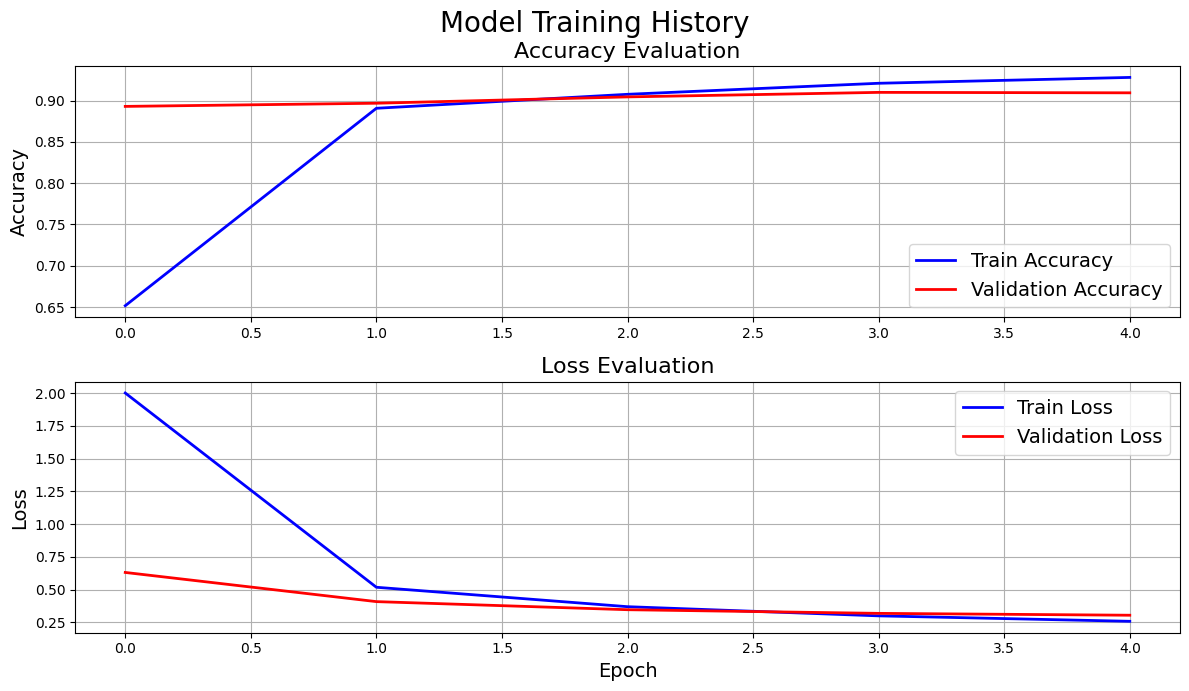

In [ ]:
# Visualize training history

fig, axs = plt.subplots(2, figsize=(12,7))

# Create accuracy subplot
axs[0].plot(history.history["accuracy"], label="Train Accuracy", color='b', linewidth=2)
axs[0].plot(history.history["val_accuracy"], label="Validation Accuracy", color='r', linewidth=2)
axs[0].set_ylabel("Accuracy", fontsize=14)
axs[0].legend(loc="lower right", fontsize=14)
axs[0].set_title("Accuracy Evaluation", fontsize=16)
axs[0].grid(True)

# Create loss subplot
axs[1].plot(history.history["loss"], label="Train Loss", color='b', linewidth=2)
axs[1].plot(history.history["val_loss"], label="Validation Loss", color='r', linewidth=2)
axs[1].set_xlabel("Epoch", fontsize=14)
axs[1].set_ylabel("Loss", fontsize=14)
axs[1].legend(loc="upper right", fontsize=14)
axs[1].set_title("Loss Evaluation", fontsize=16)
axs[1].grid(True)

# Set main title for the figure
plt.suptitle('Model Training History', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()



##Visualizing Model Performance with Confusion Matrix

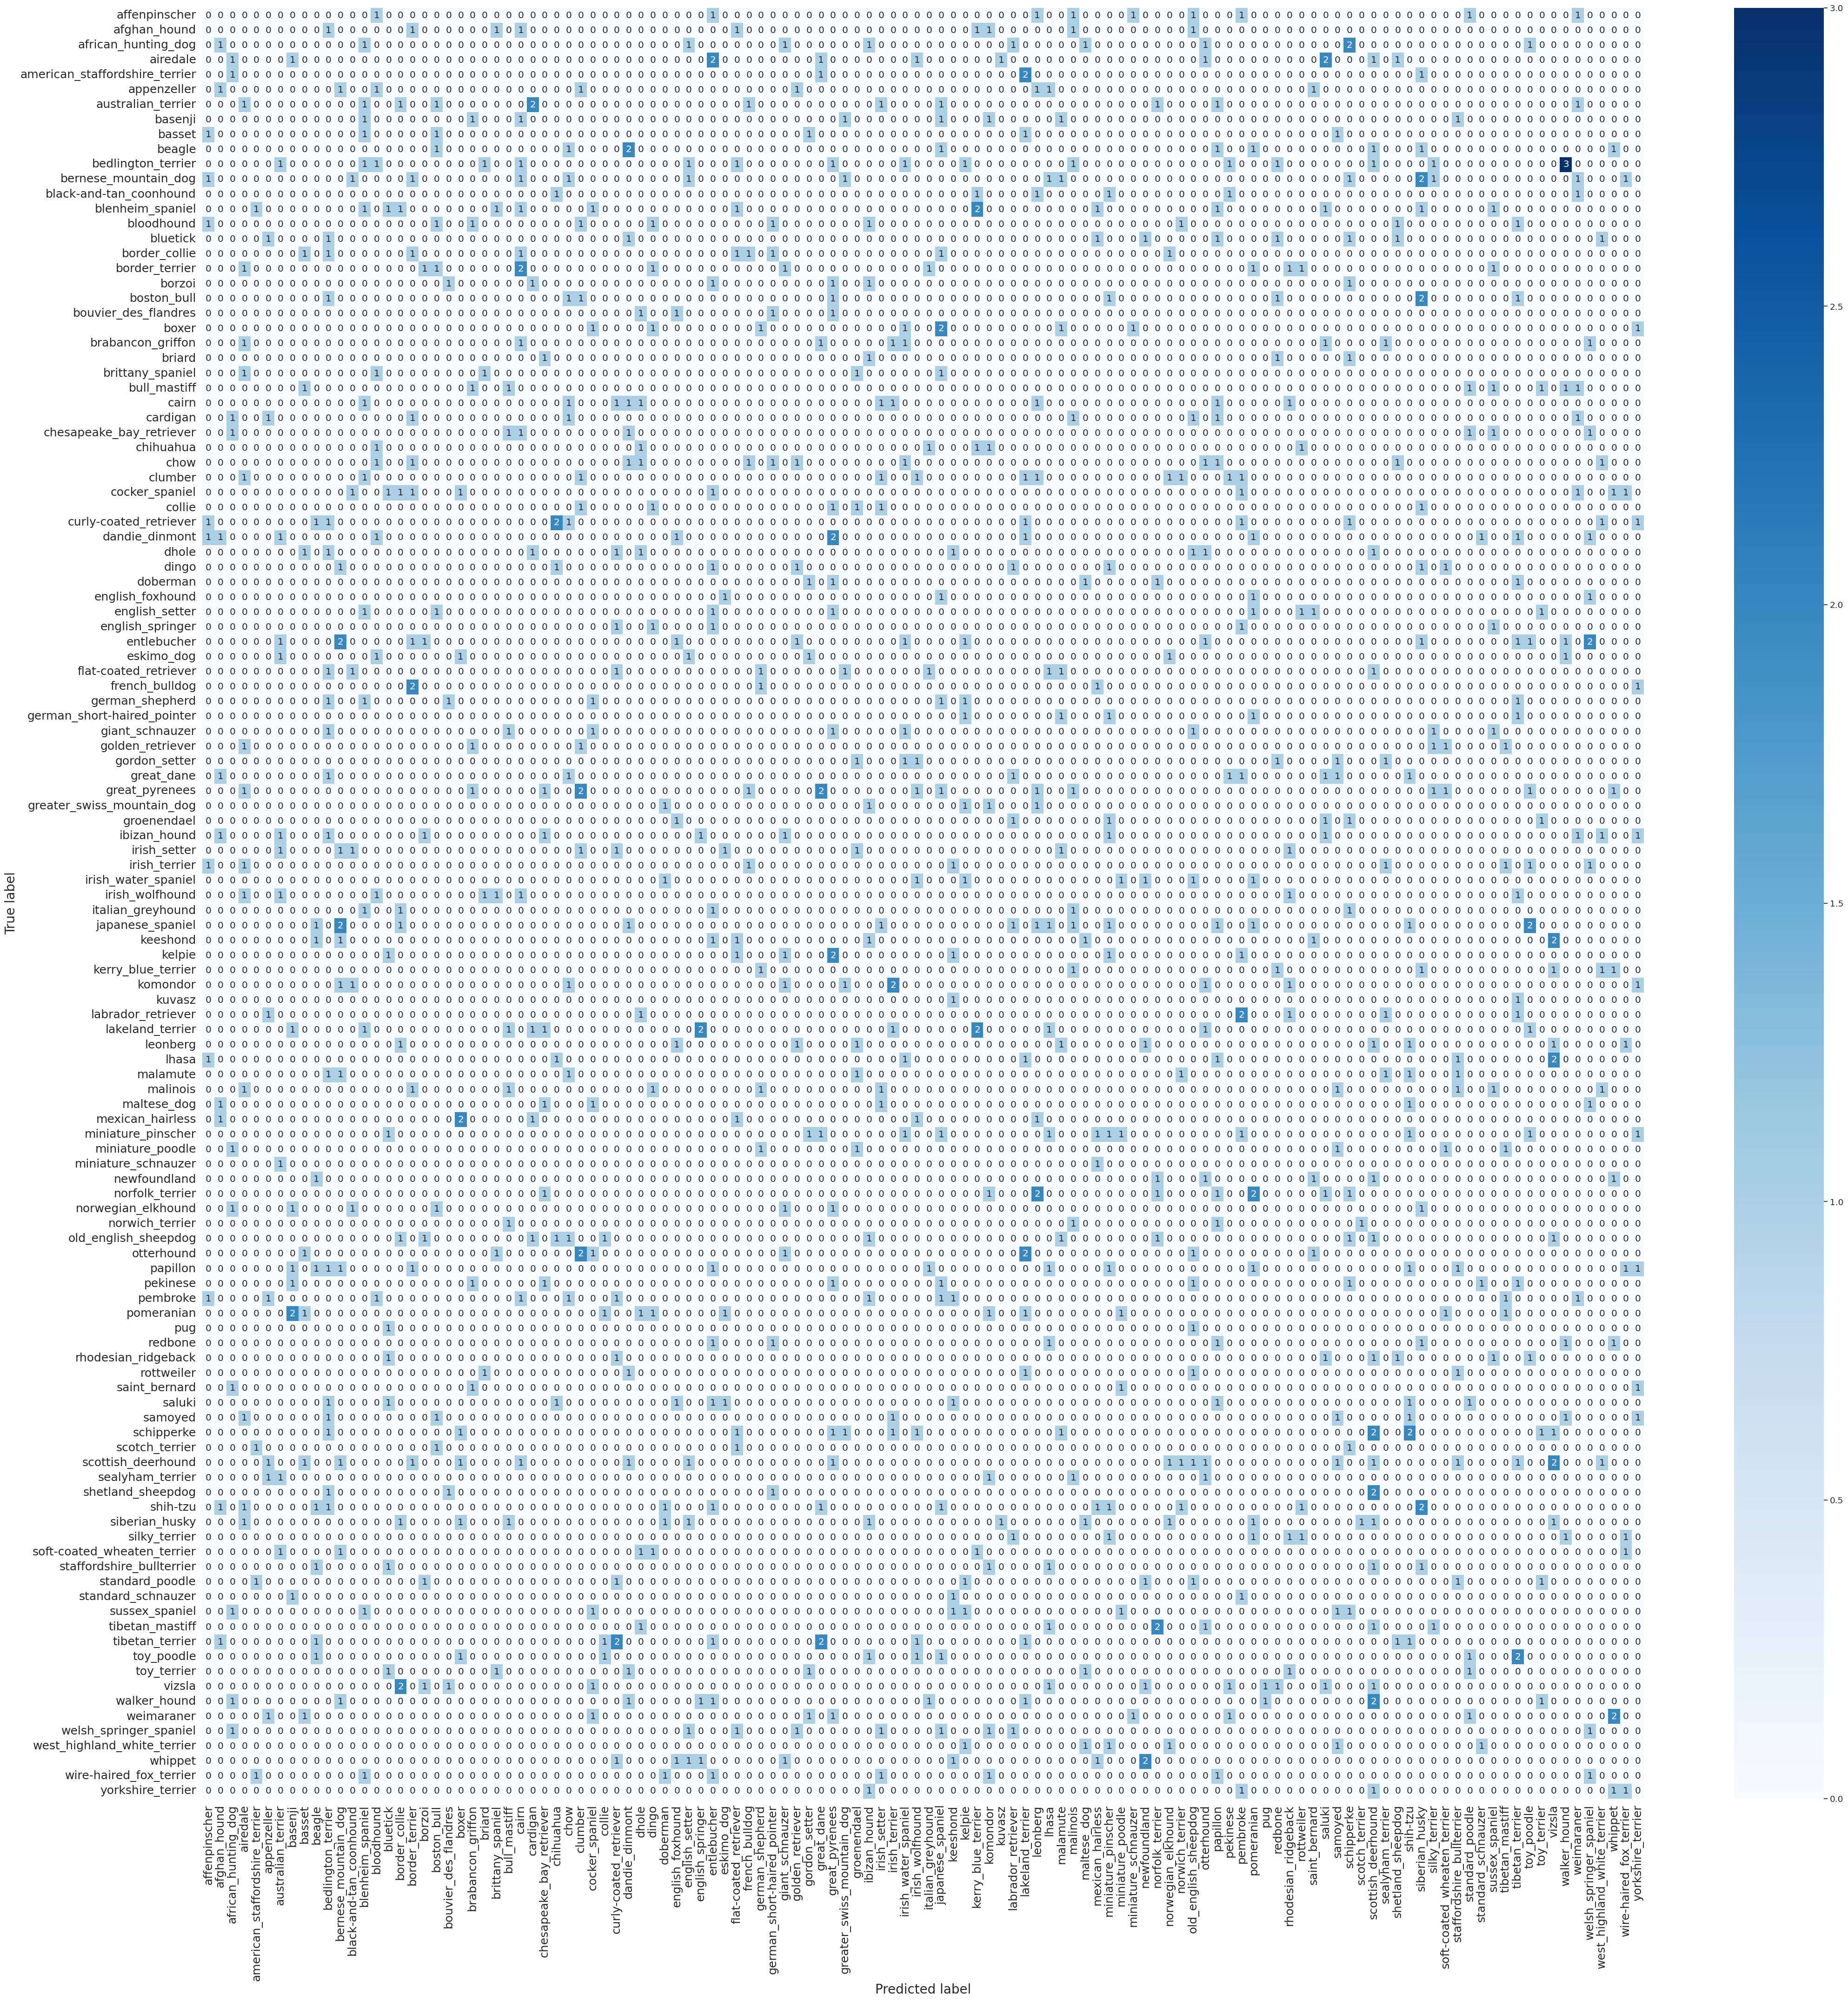

In [ ]:


# Calculate confusion matrix
confusion_mtx = confusion_matrix(test_generator.classes, y_pred_classes)

# Normalize confusion matrix
#confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Getting the list of dog breed names
class_names = test_generator.class_indices.keys()

# Plot the confusion matrix
plt.figure(figsize=(50, 50))

sns.set(font_scale=1.2)
hm = sns.heatmap(confusion_mtx, annot=True, fmt=".0f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Improve the visibility of the labels
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18)

plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()



In [ ]:
# Save final model
model.save('final_model.h5')


In [ ]:
# Load model


model_loaded = load_model('final_model.h5')

score = model_loaded.evaluate(test_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


32/32 [==============================] - 10s 292ms/step - loss: 0.2825 - accuracy: 0.9150
Test loss: 0.2824813425540924
Test accuracy: 0.9149560332298279


In [ ]:
!cp /content/final_model.h5 /content/drive/MyDrive/dog_breed/
